# Initialization

Run the following code to import the modules you'll need. After your finish the assignment, **remember to run all cells** and save the note book to your local machine as a PDF for gradescope submission.

In [4]:
import time
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Download data

In this section we will download the data and setup the paths.


In [ ]:
# Download the data
if not os.path.exists('/content/aerialseq.npy'):
    !wget https://www.cs.cmu.edu/~deva/data/aerialseq.npy -O /content/aerialseq.npy
if not os.path.exists('/content/antseq.npy'):
    !wget https://www.cs.cmu.edu/~deva/data/antseq.npy -O /content/antseq.npy

# Q4: Efficient Tracking

## Q4.1: Inverse Composition (15 points)

In [18]:
from scipy.interpolate import RectBivariateSpline

def InverseCompositionAffine(It, It1, threshold, num_iters):
    """
    :param It        : (H, W), current image
    :param It1       : (H, W), next image
    :param threshold : (float), if the length of dp < threshold, terminate the optimization
    :param num_iters : (int), number of iterations for running the optimization

    :return: M       : (2, 3) The affine transform matrix
    """
    # Initial M
    M = np.array([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0]])

    # ===== your code here! =====
    H, W = It.shape
    # Create a grid of (x, y) coordinates for the entire template image It
    X, Y = np.meshgrid(np.arange(W), np.arange(H))
    X_flat = X.flatten()
    Y_flat = Y.flatten()
    T = It.flatten()  # Template image (vectorized)

    # Compute the gradients of the template (It). Note: np.gradient returns [∂T/∂y, ∂T/∂x]
    T_dy, T_dx = np.gradient(It)
    T_dx_flat = T_dx.flatten()
    T_dy_flat = T_dy.flatten()

    # Pre-compute the steepest descent images using the Jacobian at the identity warp.
    # For an affine warp parameterized as:
    #   x' = (1 + p1)*x + p2*y + p3,
    #   y' = p4*x + (1 + p5)*y + p6,
    # the Jacobian at p=0 is:
    #   [ x,   y,   1,   0,   0,   0 ]
    #   [ 0,   0,   0,   x,   y,   1 ]
    # Therefore, for each pixel, the steepest descent images are:
    #   [T_dx*x, T_dx*y, T_dx, T_dy*x, T_dy*y, T_dy]
    SD = np.vstack((T_dx_flat * X_flat,
                    T_dx_flat * Y_flat,
                    T_dx_flat,
                    T_dy_flat * X_flat,
                    T_dy_flat * Y_flat,
                    T_dy_flat)).T  # Shape: (n_pixels, 6)

    # Compute the Hessian matrix (which is constant) and its inverse
    H_matrix = SD.T @ SD  # (6 x 6)
    H_inv = np.linalg.inv(H_matrix)

    # Create an interpolation spline for the current image It1
    It1_spline = RectBivariateSpline(np.arange(H), np.arange(W), It1)

    # Initialize the affine warp M as the 2x3 identity matrix
    M = np.array([[1.0, 0.0, 0.0],
                  [0.0, 1.0, 0.0]])

    for _ in range(num_iters):
        # Warp the template coordinates using the current affine warp M
        X_warp = M[0, 0] * X_flat + M[0, 1] * Y_flat + M[0, 2]
        Y_warp = M[1, 0] * X_flat + M[1, 1] * Y_flat + M[1, 2]

        # Determine the valid pixels that fall within the bounds of It1
        valid_idx = (X_warp >= 0) & (X_warp <= W - 1) & (Y_warp >= 0) & (Y_warp <= H - 1)
        if np.sum(valid_idx) == 0:
            break  # Exit if no pixels are valid

        # Select only the valid pixels for computing the error
        T_valid = T[valid_idx]
        SD_valid = SD[valid_idx]
        X_warp_valid = X_warp[valid_idx]
        Y_warp_valid = Y_warp[valid_idx]

        # Interpolate the warped image It1 at the valid warped coordinates
        I_warp_valid = It1_spline.ev(Y_warp_valid, X_warp_valid)

        # Compute the error between the warped current image and the template.
        # In the inverse compositional formulation, we linearize around the template,
        # so the error is: error = I(W(x; p)) - T(x)
        error = I_warp_valid - T_valid

        # Compute the parameter update dp using the pre-computed Hessian and the steepest descent images
        dp = H_inv @ (SD_valid.T @ error)

        # Check for convergence: if the norm of dp is below the threshold, terminate the loop.
        if np.linalg.norm(dp) < threshold:
            break

        # Form the incremental warp ΔM corresponding to dp:
        # ΔM = [ [1+dp1,    dp2,    dp3],
        #        [  dp4,  1+dp5,    dp6],
        #        [   0,      0,      1 ] ]
        delta_M = np.array([[1 + dp[0], dp[1], dp[2]],
                            [dp[3], 1 + dp[4], dp[5]],
                            [0, 0, 1]])

        # Update the warp: M ← M * (ΔM)⁻¹  (inverse composition update)
        delta_M_inv = np.linalg.inv(delta_M)
        M_extended = np.vstack((M, np.array([0, 0, 1])))
        M_updated = M_extended @ delta_M_inv
        M = M_updated[0:2, :]
    # ===== End of code =====
    return M

## Debug Q4.1



Feel free to use and modify the following snippet to debug your implementation. The snippet simply visualizes the translation resulting from running LK on a single frame. When you warp the source frame using the obtained transformation matrix, it should resemble the target frame.

Text(0.5, 1.0, 'Warped Source image')

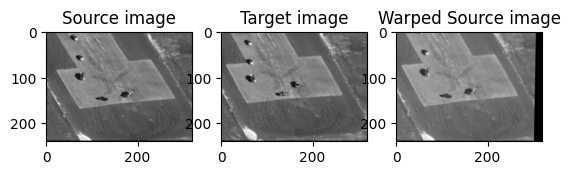

In [19]:
import cv2

num_iters = 100
threshold = 0.01
seq = np.load("aerialseq.npy")
It = seq[:,:,0]
It1 = seq[:,:,10]

# Source frame
plt.figure()
plt.subplot(1,3,1)
plt.imshow(It, cmap='gray')
plt.title('Source image')

# Target frame
plt.subplot(1,3,2)
plt.imshow(It1, cmap='gray')
plt.title('Target image')

# Warped source frame
M = InverseCompositionAffine(It, It1, threshold, num_iters)
warped_It = cv2.warpAffine(It, M,(It.shape[1],It.shape[0]))
plt.subplot(1,3,3)
plt.imshow(warped_It, cmap='gray')
plt.title('Warped Source image')

## Q4.2 Tracking with Inverse Composition (10 points)

Re-use your impplementation in Q3.2 for subtract dominant motion. Just make sure to use InverseCompositionAffine within.

In [20]:
import numpy as np
from scipy.ndimage import binary_erosion
from scipy.ndimage import binary_dilation
from scipy.ndimage import affine_transform
import scipy.ndimage
import cv2

def SubtractDominantMotion(It, It1, num_iters, threshold, tolerance):
    """
    :param It        : (H, W), current image
    :param It1       : (H, W), next image
    :param num_iters : (int), number of iterations for running the optimization
    :param threshold : (float), if the length of dp < threshold, terminate the optimization
    :param tolerance : (float), binary threshold of intensity difference when computing the mask
    :return: mask    : (H, W), the mask of the moved object
    """
    mask = np.ones(It.shape, dtype=bool)

    # ===== your code here! =====
        # Compute the dominant affine transformation matrix M using LucasKanadeAffine
    M = InverseCompositionAffine(It, It1, threshold, num_iters)
    
    # Warp image It to align with It1 using the computed affine transformation M.
    # Note: cv2.warpAffine expects the size in (width, height) order.
    H, W = It.shape
    It_warped = cv2.warpAffine(It, M, (W, H))
    
    # Compute the absolute difference between the warped image and It1.
    diff = np.abs(It1 - It_warped)
    
    # Threshold the difference to create a binary mask of moving regions.
    mask = diff > tolerance
    
    # Optionally, refine the mask using morphological operations:
    # Apply binary erosion followed by dilation to remove noise.
    mask = binary_dilation(binary_erosion(mask))
    # ===== End of code =====

    return mask


Re-use your implementation in Q3.3 for sequence tracking.

In [21]:
from tqdm import tqdm

def TrackSequenceAffineMotion(seq, num_iters, threshold, tolerance):
    """
    :param seq       : (H, W, T), sequence of frames
    :param num_iters : int, number of iterations for running the optimization
    :param threshold : float, if the length of dp < threshold, terminate the optimization
    :param tolerance : (float), binary threshold of intensity difference when computing the mask
    :return: masks   : (T, 4) moved objects for each frame
    """
    H, W, N = seq.shape

    rects =[]
    It = seq[:,:,0]

    # ===== your code here! =====
    masks = []
    for i in tqdm(range(1, seq.shape[2])):
        It_current = seq[:, :, i-1]
        It_next = seq[:, :, i]
        current_mask = SubtractDominantMotion(It_current, It_next, num_iters, threshold, tolerance)
        masks.append(current_mask)
    # ===== End of code =====
    masks = np.stack(masks, axis=2)
    return masks

Track the ant sequence with inverse composition method.


In [22]:
seq = np.load("antseq.npy")

# NOTE: feel free to play with these parameters
num_iters = 1000
threshold = 0.01
tolerance = 0.2

tic = time.time()
masks = TrackSequenceAffineMotion(seq, num_iters, threshold, tolerance)
toc = time.time()
print('\nAnt Sequence takes %f seconds' % (toc - tic))

100%|██████████| 124/124 [00:09<00:00, 12.92it/s]



Ant Sequence takes 9.664032 seconds


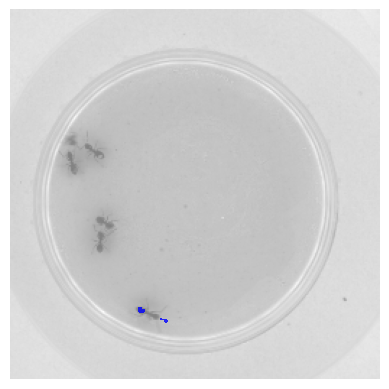

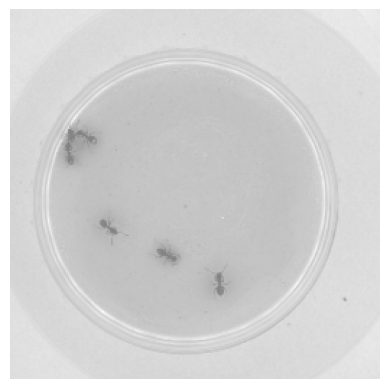

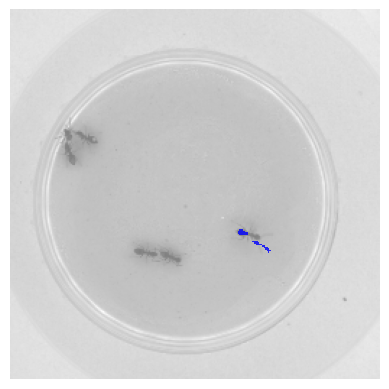

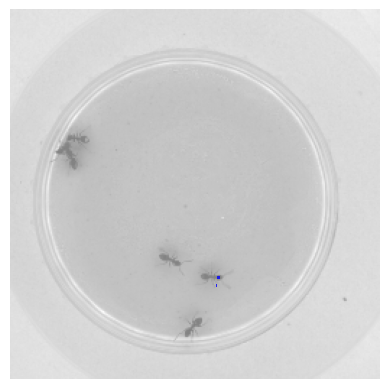

In [23]:
frames_to_save = [29, 59, 89, 119]

# TODO: visualize
for idx in frames_to_save:
    frame = seq[:, :, idx]
    mask = masks[:, :, idx]

    plt.figure()
    plt.imshow(frame, cmap="gray", alpha=0.5)
    plt.imshow(np.ma.masked_where(np.invert(mask), mask), cmap='winter', alpha=0.8)
    plt.axis('off')


Track the aerial sequence with inverse composition method.


In [24]:
seq = np.load("aerialseq.npy")

# NOTE: feel free to play with these parameters
num_iters = 1000
threshold = 0.01
tolerance = 0.2

tic = time.time()
masks = TrackSequenceAffineMotion(seq, num_iters, threshold, tolerance)
toc = time.time()
print('\nAnt Sequence takes %f seconds' % (toc - tic))

100%|██████████| 149/149 [00:24<00:00,  6.13it/s]


Ant Sequence takes 24.411206 seconds


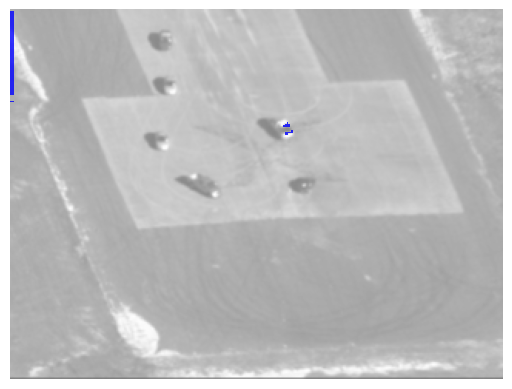

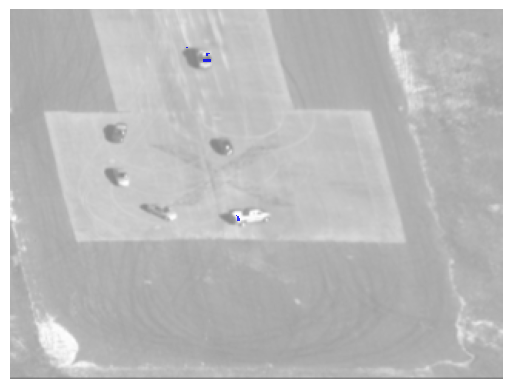

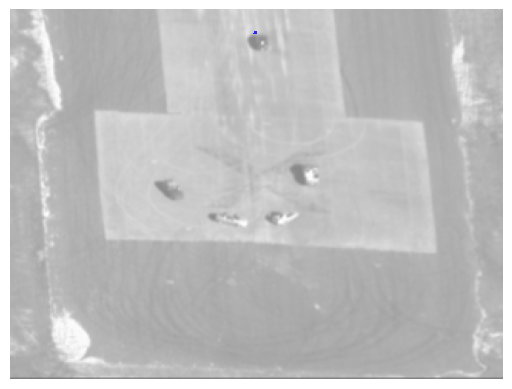

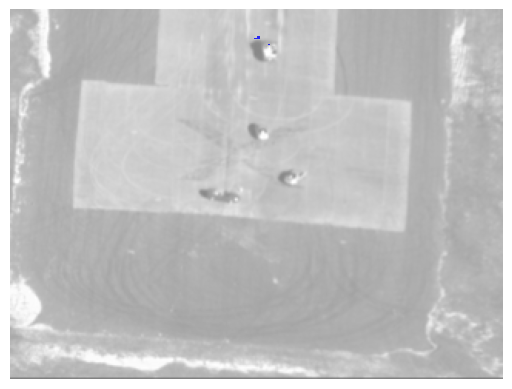

In [25]:
frames_to_save = [29, 59, 89, 119]

# TODO: visualize
for idx in frames_to_save:
    frame = seq[:, :, idx]
    mask = masks[:, :, idx]

    plt.figure()
    plt.imshow(frame, cmap="gray", alpha=0.5)
    plt.imshow(np.ma.masked_where(np.invert(mask), mask), cmap='winter', alpha=0.8)
    plt.axis('off')

## Q4.2.1 Compare the runtime of the algorithm using inverse composition (as described in this section) with its runtime without inverse composition (as detailed in the previous section) in the context of the ant and aerial sequences:
===== your answer here! =====
1. **W/o Inverse Composition:** 
- Ant Sequence: 35.96s
- Aerial Sequence: 82.88s

2. **Inverse Composition:**
- Ant Sequence: 9.66s
- Aerial Sequence: 24.11s

The inverse composition algorithm executed the processing of antseq.npy and aerialseq.npy roughly 350% faster on average.


===== end of your answer ====

## Q4.2.2 In your own words, please describe briefly why the inverse compositional approach is more computationally efficient than the classical approach:
===== your answer here! =====
The major reason for this speed up is the precomputation. By precomputing the template gradients, steepest descent images, and Hessian matrix because the linearizatio is about the fixed template, we don't have to recompute them on every iteration and can focus only on the things that changed in the image, greatly speeding up the runtime.
===== end of your answer ====